# Let's first plot arrondisements of Paris

In [177]:
import pandas as pd

In [178]:
df=pd.read_html("https://en.wikipedia.org/wiki/Arrondissements_of_Paris")[2]
df.head()

Arrondissement (R for Right Bank, L for Left Bank)            Name  \
0                                         1st (Ie) R          Louvre   
1                                        2nd (IIe) R          Bourse   
2                                       3rd (IIIe) R          Temple   
3                                        4th (IVe) R  Hôtel-de-Ville   
4                                         5th (Ve) L        Panthéon   

                Area (km2)  Population(March 1999 census)  \
0  1.826 km2 (0.705 sq mi)                          16888   
1  0.992 km2 (0.383 sq mi)                          19585   
2  1.171 km2 (0.452 sq mi)                          34248   
3  1.601 km2 (0.618 sq mi)                          30675   
4  2.541 km2 (0.981 sq mi)                          58849   

   Population(July 2005 estimate) Density (2005)(inhabitants per km2)  \
0                           17700                                9693   
1                           20700                               20867   
2                           35100                               29974   
3                           28600                               17864   
4                           60600                               23849   

  Peak of population                       Mayor  
0        before 1861  Jean-François Legaret (LR)  
1        before 1861     Jacques Boutault (EELV)  
2        before 1861       Pierre Aidenbaum (PS)  
3        before 1861             Ariel Weil (PS)  
4               1911      Florence Berthout (LR)

In [179]:
paris_master_data=df[["Arrondissement (R for Right Bank, L for Left Bank)","Name","Area (km2)","Population(July 2005 estimate)"]]

In [180]:
#Renaming the files for ease of handling
paris_master_data=paris_master_data.rename(columns={"Arrondissement (R for Right Bank, L for Left Bank)":"Arrondisement","Population(July 2005 estimate)":"Population"})

In [181]:
#re is text handling libray

import re
paris_master_data["Area (km2)"]= paris_master_data["Area (km2)"].str.split(" ").str[0]
paris_master_data["Arrondisement"]= paris_master_data["Arrondisement"].str.split(" ").str[0]

#paris_master_data["Arrondisement"]= paris_master_data["Arrondisement"]+" Arrondisement"

paris_master_data.head()

Arrondisement            Name Area (km2)  Population
0           1st          Louvre  1.826 km2       17700
1           2nd          Bourse  0.992 km2       20700
2           3rd          Temple  1.171 km2       35100
3           4th  Hôtel-de-Ville  1.601 km2       28600
4           5th        Panthéon  2.541 km2       60600

## Now let's find the geodata for the arrondisement 

In [6]:
from geopy.geocoders import Nominatim

for x in range (0,len(paris_master_data)): 
    address = paris_master_data.loc[x,"Name"]+ " Paris"
    geolocator = Nominatim(user_agent="tt_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    paris_master_data.loc[x,"longitude"]=longitude
    paris_master_data.loc[x,"Latitude"]=latitude
paris_master_data.head()
Paris=paris_master_data

In [7]:
#slightly tweaking the cordinates of two arrondisements based on empirical knowledge

Paris.loc[15,"longitude"]=2.27573
Paris.loc[11,"longitude"]=2.40214
Paris.loc[15,"Latitude"]=48.8652
Paris.loc[11,"Latitude"]=48.8352

# ## Let's plot these points on a map




In [8]:

#!conda install -c conda-forge folium=0.5.0 --yes

#from sklearn import preprocessing
#min_max_scaler = preprocessing.MinMaxScaler()


import folium
paris_population = folium.Map(location=[48.8566, 2.3522],zoom_start=12.2)


text="tesg"
for lat, lng, name, arr, pop in zip(Paris['Latitude'], Paris['longitude'], Paris["Name"], Paris["Arrondisement"],Paris["Population"] ):
    label = '{}, {}'.format(name, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=pop/7000,
    popup=label,
    color='crimson',
    fill=True,
    fill_color='crimson',
    fill_opacity=0.7,
    parse_html=False).add_to(paris_population)  
    
    folium.Marker(
    [lat, lng],
    icon=folium.DivIcon(
    icon_size=(10,36),
    icon_anchor=(0,0),
    html='<div style="color:#3395FF;font-weight:bold" >%s</div>' % arr,
    )
    ).add_to(paris_population)

paris_population

Solving environment: done

# All requested packages already installed.



### Alsp plotting the population density

In [182]:

Paris["Population density"]=Paris["Population"]/Paris["Area (km2)"].str.split("\\s+").str[0].astype(float)


In [11]:
paris_population_density = folium.Map(location=[48.8566, 2.3522],zoom_start=12.2)


for lat, lng, name, arr, pop, pop_density in zip(Paris['Latitude'], Paris['longitude'], Paris["Name"], 
                                                Paris["Arrondisement"],Paris["Population"],Paris["Population density"] ):
    label = '{}, {}'.format(name, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=pop_density/2000,
    popup=label,
    color='crimson',
    fill=True,
    fill_color='crimson',
    fill_opacity=0.7,
    parse_html=False).add_to(paris_population_density)  
    
    folium.Marker(
    [lat, lng],
    icon=folium.DivIcon(
    icon_size=(10,36),
    icon_anchor=(0,0),
    html='<div style="color:#3395FF;font-weight:bold" >%s</div>' % arr,
    )
    ).add_to(paris_population_density)

paris_population_density

# Importing the data from foursquare API

In [185]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section=food'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
   
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        #print("results")
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

      
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    
    
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    

    return(nearby_venues)


In [14]:
import requests
print (LIMIT)
paris_food = getNearbyVenues(names=Paris['Arrondisement'],
                                   latitudes=Paris['Latitude'],
                                   longitudes=Paris['longitude']
                                  )

300


In [186]:
paris_food=paris_food.rename(columns={"Neighborhood":"Arrondisement"})
paris_food.head()

Arrondisement  Neighborhood Latitude  Neighborhood Longitude  \
0           1st              48.861147                2.338028   
2           1st              48.861147                2.338028   
4           1st              48.861147                2.338028   
5           1st              48.861147                2.338028   
7           1st              48.861147                2.338028   

               Venue  Venue Latitude  Venue Longitude      Venue Category  
0             LouLou       48.862804         2.333500  Italian Restaurant  
2          Ellsworth       48.865528         2.337057   French Restaurant  
4           Le Louis       48.864331         2.341332   French Restaurant  
5           Sanukiya       48.864713         2.333805     Udon Restaurant  
7  Les Fines Gueules       48.865172         2.340645   French Restaurant

# Plotting the restaurants on the Map

In [167]:

paris_food_map = folium.Map(location=[48.8566, 2.3522],zoom_start=12.2)

for lat, lng, Venuename, arr, in zip(paris_food['Venue Latitude'], paris_food['Venue Longitude'], paris_food["Venue"], paris_food["Arrondisement"]):
    label = '{}, {}'.format(arr,Venuename)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(paris_food_map)  
    
paris_food_map

### changing the restaurant type to remove duplication for e.g replacing sushi restaurant with japanese restaurant

In [20]:
# replacing the duplicate categories 
paris_food["Venue Category"]=paris_food["Venue Category"].replace("Pizza Place","Italian Restaurant")
paris_food["Venue Category"]=paris_food["Venue Category"].replace("Sushi Restaurant","Japanese Restaurant")
paris_food["Venue Category"]=paris_food["Venue Category"].replace("Asian Restaurant","Kor/Thai/chin/viet")
paris_food["Venue Category"]=paris_food["Venue Category"].replace("Chinese Restaurant","Kor/Thai/chin/viet")
paris_food["Venue Category"]=paris_food["Venue Category"].replace("New American Restaurant","American Restaurant")
paris_food["Venue Category"]=paris_food["Venue Category"].replace("Thai Restaurant","Kor/Thai/chin/viet")
paris_food["Venue Category"]=paris_food["Venue Category"].replace("Korean Restaurant","Kor/Thai/chin/viet")
paris_food["Venue Category"]=paris_food["Venue Category"].replace("Vietnamese Restaurant","Kor/Thai/chin/viet")


In [21]:
#Replacing the categories which are not per se restuarant 
paris_food=paris_food[paris_food["Venue Category"]!= "Restaurant"]
paris_food=paris_food[paris_food["Venue Category"]!= "Bistro"]
paris_food=paris_food[paris_food["Venue Category"]!= "Café"]
paris_food=paris_food[paris_food["Venue Category"]!= "Bakery"]
paris_food=paris_food[paris_food["Venue Category"]!= "Sandwich Place"]

In [22]:
paris_food["Venue Category"].value_counts()
paris_food_french=paris_food[paris_food["Venue Category"]== "French Restaurant"]

In [23]:

paris_food_italy=paris_food[paris_food["Venue Category"]== "Italian Restaurant"]

paris_food_jap=paris_food[paris_food["Venue Category"]== "Japanese Restaurant"]

paris_food_thai=paris_food[paris_food["Venue Category"]== "Kor/Thai/chin/viet"]



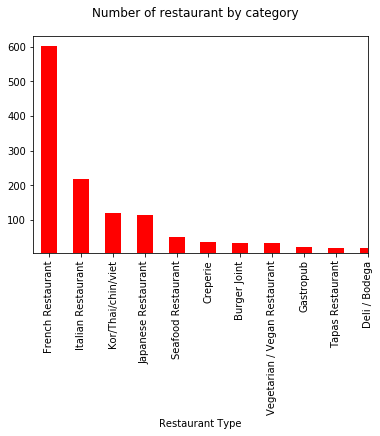

In [166]:
paris_count=paris_food["Venue Category"].value_counts()
chart1=paris_count.sort_values(ascending=False)
chart1.plot(kind='bar', color='red')

plt.xlim(right=10)
plt.ylim(5)
plt.xlabel("Restaurant Type")
plt.suptitle('Number of restaurant by category')
plt.show()

In [26]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Arrondisement'] = paris_food['Arrondisement'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

Arrondisement  African Restaurant  Alsatian Restaurant  American Restaurant  \
0           1st                   0                    0                    0   
2           1st                   0                    0                    0   
4           1st                   0                    0                    0   
5           1st                   0                    0                    0   
7           1st                   0                    0                    0   

   Arepa Restaurant  Argentinian Restaurant  Auvergne Restaurant  BBQ Joint  \
0                 0                       0                    0          0   
2                 0                       0                    0          0   
4                 0                       0                    0          0   
5                 0                       0                    0          0   
7                 0                       0                    0          0   

   Bagel Shop  Basque Restaurant  ...  Souvlaki Shop  Spanish Restaurant  \
0           0                  0  ...              0                   0   
2           0                  0  ...              0                   0   
4           0                  0  ...              0                   0   
5           0                  0  ...              0                   0   
7           0                  0  ...              0                   0   

   Steakhouse  Szechuan Restaurant  Taco Place  Tapas Restaurant  \
0           0                    0           0                 0   
2           0                    0           0                 0   
4           0                    0           0                 0   
5           0                    0           0                 0   
7           0                    0           0                 0   

   Trattoria/Osteria  Turkish Restaurant  Udon Restaurant  \
0                  0                   0                0   
2                  0                   0                0   
4                  0                   0                0   
5                  0                   0                1   
7                  0                   0                0   

   Vegetarian / Vegan Restaurant  
0                              0  
2                              0  
4                              0  
5                              0  
7                              0  

[5 rows x 74 columns]

In [27]:
paris_onehot.shape

(1652, 74)

In [28]:
paris_grouped = paris_onehot.groupby('Arrondisement').mean().reset_index()

In [29]:
paris_grouped.shape

(20, 74)

In [31]:
paris_grouped.iloc[2:3,1:].sum(axis=1)

2    1.0
dtype: float64

In [32]:
import numpy as np

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues



columns = ['Arrondisement']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

        
# create a new dataframe
arr_venues_sorted = pd.DataFrame(columns=columns)
arr_venues_sorted['Arrondisement'] = paris_grouped['Arrondisement']

for ind in np.arange(paris_grouped.shape[0]):
    arr_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

arr_venues_sorted

Arrondisement 1st Most Common Venue 2nd Most Common Venue  \
0           10th    Italian Restaurant     French Restaurant   
1           11th     French Restaurant    Italian Restaurant   
2           12th     French Restaurant    Kor/Thai/chin/viet   
3           13th     French Restaurant    Kor/Thai/chin/viet   
4           14th     French Restaurant    Italian Restaurant   
5           15th     French Restaurant   Japanese Restaurant   
6           16th     French Restaurant    Italian Restaurant   
7           17th     French Restaurant    Italian Restaurant   
8           18th     French Restaurant    Italian Restaurant   
9           19th     French Restaurant    Italian Restaurant   
10           1st     French Restaurant   Japanese Restaurant   
11          20th     French Restaurant    Kor/Thai/chin/viet   
12           2nd     French Restaurant    Italian Restaurant   
13           3rd     French Restaurant    Italian Restaurant   
14           4th     French Restaurant    Italian Restaurant   
15           5th     French Restaurant    Italian Restaurant   
16           6th     French Restaurant    Italian Restaurant   
17           7th     French Restaurant    Italian Restaurant   
18           8th     French Restaurant    Italian Restaurant   
19           9th     French Restaurant   Japanese Restaurant   

            3rd Most Common Venue 4th Most Common Venue  \
0              Kor/Thai/chin/viet   Japanese Restaurant   
1              Kor/Thai/chin/viet   Japanese Restaurant   
2              Italian Restaurant   Japanese Restaurant   
3              Italian Restaurant   Japanese Restaurant   
4              Kor/Thai/chin/viet   Japanese Restaurant   
5              Italian Restaurant    Kor/Thai/chin/viet   
6             Japanese Restaurant            Steakhouse   
7             Japanese Restaurant    Kor/Thai/chin/viet   
8   Vegetarian / Vegan Restaurant    Kor/Thai/chin/viet   
9              Kor/Thai/chin/viet     Indian Restaurant   
10             Italian Restaurant   Lebanese Restaurant   
11             Italian Restaurant   Moroccan Restaurant   
12            Japanese Restaurant    Seafood Restaurant   
13             Kor/Thai/chin/viet   Japanese Restaurant   
14            Japanese Restaurant          Burger Joint   
15             Seafood Restaurant              Creperie   
16            Japanese Restaurant    Seafood Restaurant   
17            Japanese Restaurant    Kor/Thai/chin/viet   
18             Kor/Thai/chin/viet    Falafel Restaurant   
19             Italian Restaurant    Kor/Thai/chin/viet   

            5th Most Common Venue          6th Most Common Venue  \
0              Seafood Restaurant  Vegetarian / Vegan Restaurant   
1              Seafood Restaurant  Vegetarian / Vegan Restaurant   
2                      Food Truck                     Bagel Shop   
3                    Burger Joint                       Creperie   
4                        Creperie                   Burger Joint   
5             Lebanese Restaurant              Basque Restaurant   
6                    Burger Joint             Seafood Restaurant   
7              Seafood Restaurant                   Burger Joint   
8               Indian Restaurant            Japanese Restaurant   
9              Seafood Restaurant            Japanese Restaurant   
10             Seafood Restaurant                       Creperie   
11            Japanese Restaurant             Mexican Restaurant   
12  Vegetarian / Vegan Restaurant                   Burger Joint   
13  Vegetarian / Vegan Restaurant                 Breakfast Spot   
14             Seafood Restaurant                  Deli / Bodega   
15            Japanese Restaurant            Lebanese Restaurant   
16            Lebanese Restaurant                       Creperie   
17            American Restaurant            Lebanese Restaurant   
18               Tapas Restaurant                       Creperie   
19  Vegetarian / Vegan Restaurant                       Cr

In [176]:
arr_venues_sorted.to_excel(r'C:\Users\mohit\Downloads\check.xlsx')

# Clustering the data using Kmeans algorithm

In [188]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 4

#drop column n 
paris_grouped_clustering = paris_grouped.drop('Arrondisement', 1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)



In [36]:
# add clustering labels
arr_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = paris_food

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(arr_venues_sorted.set_index('Arrondisement'), on='Arrondisement')

paris_merged.head() # check the last columns!

Arrondisement  Neighborhood Latitude  Neighborhood Longitude  \
0           1st              48.861147                2.338028   
2           1st              48.861147                2.338028   
4           1st              48.861147                2.338028   
5           1st              48.861147                2.338028   
7           1st              48.861147                2.338028   

               Venue  Venue Latitude  Venue Longitude      Venue Category  \
0             LouLou       48.862804         2.333500  Italian Restaurant   
2          Ellsworth       48.865528         2.337057   French Restaurant   
4           Le Louis       48.864331         2.341332   French Restaurant   
5           Sanukiya       48.864713         2.333805     Udon Restaurant   
7  Les Fines Gueules       48.865172         2.340645   French Restaurant   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               0     French Restaurant   Japanese Restaurant   
2               0     French Restaurant   Japanese Restaurant   
4               0     French Restaurant   Japanese Restaurant   
5               0     French Restaurant   Japanese Restaurant   
7               0     French Restaurant   Japanese Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Italian Restaurant   Lebanese Restaurant    Seafood Restaurant   
2    Italian Restaurant   Lebanese Restaurant    Seafood Restaurant   
4    Italian Restaurant   Lebanese Restaurant    Seafood Restaurant   
5    Italian Restaurant   Lebanese Restaurant    Seafood Restaurant   
7    Italian Restaurant   Lebanese Restaurant    Seafood Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0              Creperie       Udon Restaurant          Burger Joint   
2              Creperie       Udon Restaurant          Burger Joint   
4              Creperie       Udon Restaurant          Burger Joint   
5              Creperie       Udon Restaurant          Burger Joint   
7              Creperie       Udon Restaurant          Burger Joint   

  9th Most Common Venue 10th Most Common Venue  
0         Deli / Bodega    American Restaurant  
2         Deli / Bodega    American Restaurant  
4         Deli / Bodega    American Restaurant  
5         Deli / Bodega    American Restaurant  
7         Deli / Bodega    American Restaurant

In [189]:
clus1=paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(1, paris_merged.shape[1]))]]
clus2=paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(1, paris_merged.shape[1]))]]
clus3=paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(1, paris_merged.shape[1]))]]
clus4=paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(1, paris_merged.shape[1]))]]

## Plotting the clusters

In [190]:
clus_map = folium.Map(location=[48.8566, 2.3522],zoom_start=12.2)

for lat, lng, Venuename in zip(clus1['Venue Latitude'], clus1['Venue Longitude'], clus1["Venue"]):
    label = '{}, {}'.format(arr,Venuename)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(clus_map)  
    
    
for lat, lng, Venuename in zip(clus2['Venue Latitude'], clus2['Venue Longitude'], clus2["Venue"]):
    label = '{}, {}'.format(arr,Venuename)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='Red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(clus_map)  
    
    
for lat, lng, Venuename in zip(clus3['Venue Latitude'], clus3['Venue Longitude'], clus3["Venue"]):
    label = '{}, {}'.format(arr,Venuename)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='Green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(clus_map)  
        
for lat, lng, Venuename in zip(clus4['Venue Latitude'], clus4['Venue Longitude'], clus4["Venue"]):
    label = '{}, {}'.format(arr,Venuename)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='Magenta',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(clus_map)  
    
    
clus_map

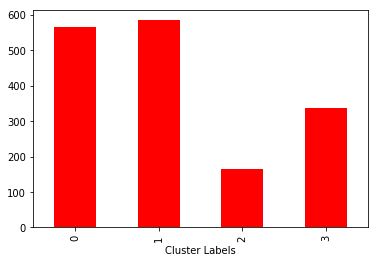

In [191]:
x=paris_merged.groupby(['Cluster Labels']).count()["Venue"].plot('bar', color='r')